In [29]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from sklearn.covariance import empirical_covariance
from scipy.stats import pearsonr
from tqdm import tqdm

In [31]:
ec_mudata = md.read("../data/preprocessed/ec_mudata_prepro.h5mu")
ec_mudata

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 9639 × 7240
  3 modalities
    all_genes:	9639 x 3620
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    high_abundance_genes:	9639 x 847
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    low_abundance_genes:	9639 x 2773
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [51]:
hag10_hcc15 = ec_mudata["high_abundance_genes"][sc.pp.filter_cells(ec_mudata["high_abundance_genes"], min_counts=15, inplace=False)[0],:]
hag10_hcc15

View of AnnData object with n_obs × n_vars = 1007 × 847
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [57]:
np.mean(np.sum(hag10_hcc15.X.A, axis=0))

28.23967

In [58]:
np.median(np.sum(hag10_hcc15.X.A, axis=0))

8.0

In [3]:
sc.pp.highly_variable_genes(ec_adata, n_top_genes=200, layer="sqrt_counts")
#sc.pp.highly_variable_genes(ec_adata, layer='norm_counts', n_top_genes=200, flavor='seurat_v3')
ec_adata_hvg200 = ec_adata[:, ec_adata.var['highly_variable']].copy()

<Axes: xlabel='total_counts', ylabel='Count'>

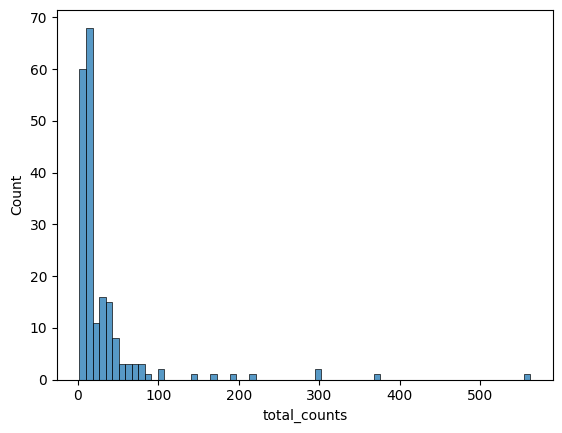

In [4]:
sns.histplot(ec_adata_hvg200.var.total_counts)

In [5]:
ec_adata_hvg200.var.total_counts.value_counts()

8.0      13
18.0     12
14.0     10
15.0     10
9.0       9
         ..
61.0      1
103.0     1
56.0      1
35.0      1
48.0      1
Name: total_counts, Length: 64, dtype: int64

In [6]:
calc_sparsity(np.array(ec_adata.X.A,dtype=bool))

0.0020469329536602853

In [7]:
calc_sparsity(np.array(ec_adata_hvg200.X.A,dtype=bool))

0.0030055139800530496

In [8]:
cov_hvg200 = empirical_covariance(ec_adata_hvg200.X.A)

In [26]:
ggl_est = gg_lasso_network_analysis(N=ec_adata_hvg200.shape[0], estimate=cov_hvg200)
ggl_est.create_problem(latent=True)
ggl_est.model_selection(lambda1_range=np.logspace(0, -10, 200))

 
SINGLE GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}


ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterations with status: optimal.
ADMM terminated after 3 iterat

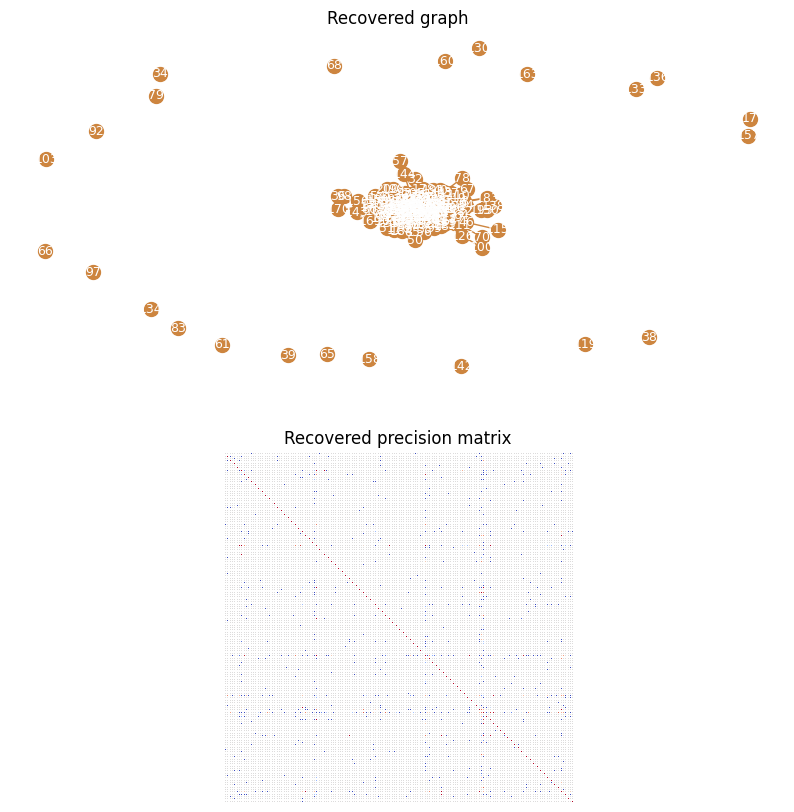

In [27]:
ggl_est.plot_graph_and_percision_matrix(fig_size=(10,10))

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


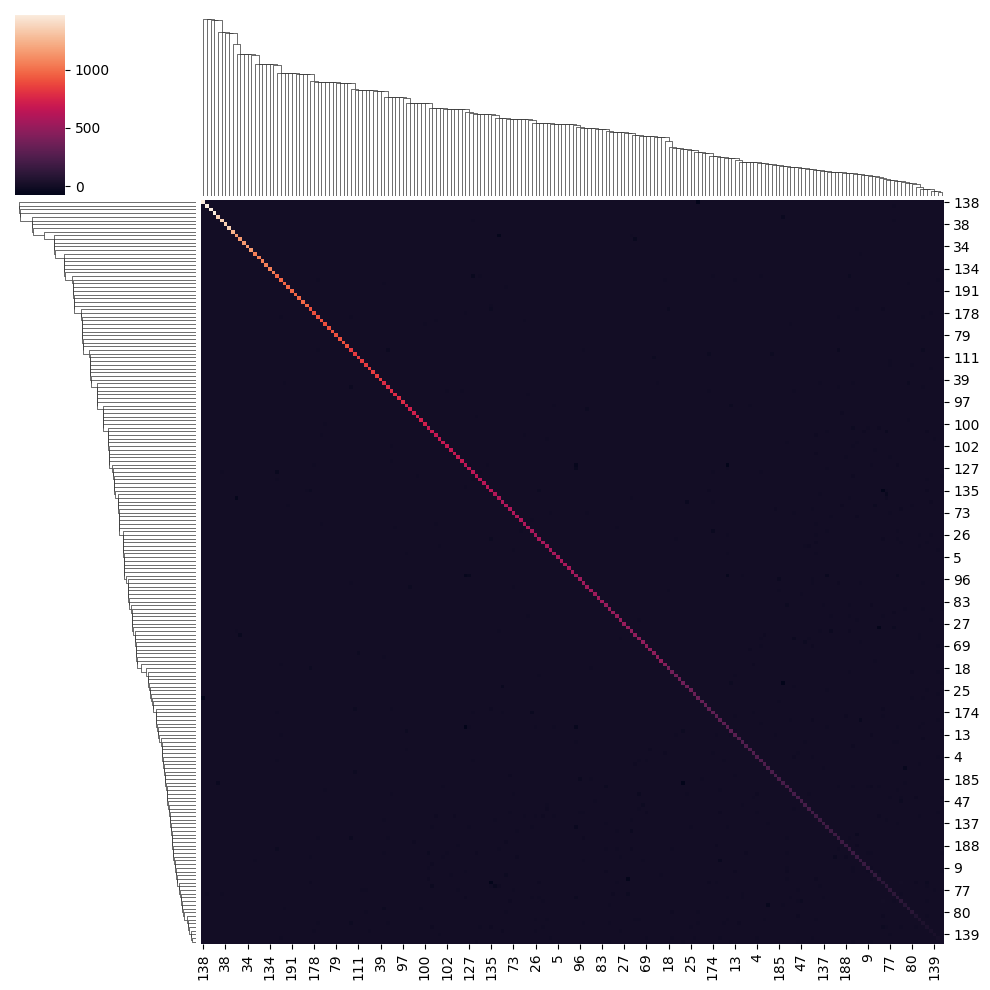

In [17]:
sns.clustermap(ggl_est.P.solution.precision_)

In [17]:
ggl_est.P.__dict__

{'S': array([[ 1.24386611e-03, -1.50682937e-06, -4.41285743e-06, ...,
         -3.22892007e-07,  2.02324131e-04, -2.15261338e-07],
        [-1.50682937e-06,  1.65781367e-03, -6.17800040e-06, ...,
         -4.52048810e-07, -7.23278095e-06, -3.01365873e-07],
        [-4.41285743e-06, -6.17800040e-06,  5.27291258e-03, ...,
         -1.32385723e-06, -2.11817156e-05, -8.82571485e-07],
        ...,
        [-3.22892007e-07, -4.52048810e-07, -1.32385723e-06, ...,
          5.18629141e-04, -1.54988163e-06, -6.45784014e-08],
        [ 2.02324131e-04, -7.23278095e-06, -2.11817156e-05, ...,
         -1.54988163e-06,  6.19991400e-03, -1.03325442e-06],
        [-2.15261338e-07, -3.01365873e-07, -8.82571485e-07, ...,
         -6.45784014e-08, -1.03325442e-06,  4.14937755e-04]]),
 'N': 9639,
 'latent': False,
 'G': None,
 'do_scaling': False,
 'conforming': True,
 'multiple': False,
 'p': 201,
 'K': 1,
 'reg_params': {'lambda1': 0.00010635449574860112, 'mu1': 0},
 'modelselect_params': {'lambda1_rang

In [22]:
sol = ggl_est.P.solution.precision_

In [25]:
sol.max()

1469.4537738516963